# Preparing dataset

Preparation of dataset the same way as [here](https://github.com/JanMatusiak/exoplanets/blob/5380110f75580a08a29b010a21c8d1a51bb5e2a4/kepler.ipynb). For more detailed information about Specific steps go there.

In [6]:
import pandas as pd
from torch.nn import BCEWithLogitsLoss
from torch.onnx.utils import model_signature

url = 'datasets/KOI.csv'
kepler_df = pd.read_csv(url, comment='#')
kepler_df.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [7]:
kepler_df.shape

(9564, 49)

### Missing values

In [8]:
kepler_df.isnull().sum().sort_values(ascending=False)

koi_teq_err1         9564
koi_teq_err2         9564
kepler_name          6817
koi_score            1510
koi_steff_err2        483
koi_srad_err1         468
koi_steff_err1        468
koi_slogg_err2        468
koi_slogg_err1        468
koi_srad_err2         468
koi_time0bk_err1      454
koi_period_err1       454
koi_period_err2       454
koi_time0bk_err2      454
koi_impact_err1       454
koi_depth_err1        454
koi_depth_err2        454
koi_duration_err1     454
koi_duration_err2     454
koi_impact_err2       454
koi_model_snr         363
koi_srad              363
koi_slogg             363
koi_steff             363
koi_depth             363
koi_prad_err1         363
koi_prad              363
koi_impact            363
koi_prad_err2         363
koi_teq               363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_insol_err2        321
koi_insol             321
koi_insol_err1        321
koi_kepmag              1
koi_fpflag_ec           0
koi_time0bk             0
koi_fpflag_n

### Colums that can be dropped

In [9]:
kepler_clean_df = kepler_df.drop(kepler_df.filter(regex="(_err1|_err2)$").columns, axis=1)
subset = ['kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname', 'koi_teq', 'koi_time0bk']
kepler_clean_df = kepler_clean_df.drop(subset, axis=1)
kepler_clean_df.isnull().sum().sort_values(ascending=False)

koi_model_snr       363
koi_prad            363
koi_depth           363
koi_impact          363
koi_srad            363
koi_slogg           363
koi_steff           363
koi_tce_plnt_num    346
koi_insol           321
koi_kepmag            1
koi_disposition       0
kepid                 0
koi_fpflag_ss         0
koi_fpflag_nt         0
koi_fpflag_ec         0
koi_period            0
koi_duration          0
koi_fpflag_co         0
ra                    0
dec                   0
dtype: int64

### Get rid of candidates to not confuse model

In [10]:
candidates_df = kepler_clean_df[kepler_clean_df["koi_disposition"].str.strip().str.upper() == "CANDIDATE"].copy()

labeled_df = kepler_clean_df[
    kepler_clean_df["koi_disposition"].str.strip().str.upper().isin(["CONFIRMED", "FALSE POSITIVE"])].copy()

labeled_df["label"] = (
    labeled_df["koi_disposition"]
    .str.strip().str.upper()
    .map({"CONFIRMED": 1, "FALSE POSITIVE": 0})
)

labeled_df.drop(["koi_disposition"], axis=1, inplace=True)
labeled_df.head(5)


,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,label
0,10797460,0,0,0,0,9.488036,0.146,2.95750,615.8,2.26,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
1,10797460,0,0,0,0,54.418383,0.586,4.50700,874.8,2.83,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
3,10848459,0,1,0,0,1.736952,1.276,2.40641,8079.2,33.46,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597,0
4,10854555,0,0,0,0,2.525592,0.701,1.65450,603.3,2.75,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,1
5,10872983,0,0,0,0,11.094321,0.538,4.59450,1517.5,3.90,114.81,66.5,1.0,6046.0,4.486,0.972,296.28613,48.224670,15.714,1


### Missing values

In [11]:
labeled_df.isnull().sum().sort_values(ascending=False)

koi_tce_plnt_num    286
koi_model_snr       259
koi_impact          259
koi_prad            259
koi_srad            259
koi_slogg           259
koi_steff           259
koi_depth           259
koi_insol           219
koi_kepmag            1
koi_fpflag_nt         0
kepid                 0
koi_fpflag_co         0
koi_fpflag_ss         0
koi_duration          0
koi_fpflag_ec         0
koi_period            0
ra                    0
dec                   0
label                 0
dtype: int64

In [12]:
labeled_df.dropna(inplace=True, axis=0)
labeled_df.isnull().sum()

kepid               0
koi_fpflag_nt       0
koi_fpflag_ss       0
koi_fpflag_co       0
koi_fpflag_ec       0
koi_period          0
koi_impact          0
koi_duration        0
koi_depth           0
koi_prad            0
koi_insol           0
koi_model_snr       0
koi_tce_plnt_num    0
koi_steff           0
koi_slogg           0
koi_srad            0
ra                  0
dec                 0
koi_kepmag          0
label               0
dtype: int64

Dataset is ready for analysis.

# Binary classification Model

### Division into features and labels

In [13]:
import numpy as np

# X = labeled_df.drop("label", axis = 1).values   # features
# y = labeled_df["label"].values                  # labels

drop = ["label", "kepid"]
feat_cols = [c for c in labeled_df.columns if c not in drop]
X = labeled_df[feat_cols]
y = labeled_df["label"]

### Standardization of features

In [14]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Conversion to tensors

In [15]:
X_scaled.shape, y.shape


((7115, 18), (7115,))

In [16]:
type(X_scaled), X_scaled.dtype

(numpy.ndarray, dtype('float64'))

In [17]:
# Turn data into tensors
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

X_scaled = torch.from_numpy(X_scaled).type(torch.float32)
y = torch.from_numpy(y.values).type(torch.float32)  # POPRAWIONE - dodaj .values


In [18]:
type(X_scaled), X_scaled.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

### train / test split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(5692, 1423, 5692, 1423)

In [20]:
type(X_train), X_train.dtype

(torch.Tensor, torch.float32)

In [21]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Construct Model Class

In [22]:
class ExoplanetsV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Create an instance of model
model_0 = ExoplanetsV0(input_features=18, output_features=1, hidden_units=64).to(device)
model_0

ExoplanetsV0(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [23]:
X_train.shape, y_train.shape

(torch.Size([5692, 18]), torch.Size([5692]))

### Loss Function and Optimizer

In [24]:
# Create a loss function for binary classification

### Tried to fix with wages-----------------------------------
weight_for_0 = len(y) / (2 * (y == 0).sum())
weight_for_1 = len(y) / (2 * (y == 1).sum())

pos_weight = torch.tensor([weight_for_1 / weight_for_0])  # dla klasy 1
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#loss_fn = nn.BCEWithLogitsLoss()
###----------------------------------------------------------

#loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer for binary classification
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

In [25]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train Model

Model outputs are raw **Logits**

We are converting logits into prediction probabilities by passing them to some kind of activation function (int this case `nn.Sigmoid()`) Then we can convert our model's prediction probabilities to **prediction labels** by taking the `argmaX_scaled()`

In [26]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0613],
        [-0.0319],
        [-0.0614],
        [-0.0806],
        [-0.0746]])

In [27]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4847],
        [0.4920],
        [0.4847],
        ...,
        [0.4859],
        [0.4981],
        [0.4795]])

In [28]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [29]:
# find predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True,  ..., True, True, True])


tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [30]:
y_test[:5]

tensor([0., 0., 0., 0., 0.])

### Building a training loop and testing loop

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Tracking loss and accuracy
track_accuracy = []
track_loss = []
track_test_accuracy = []
track_test_loss = []

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # turn logits into pred probs and into pred labels

    # 2. Calculate the loss / cost
    loss = loss_fn(y_logits, y_train)
    track_loss.append(loss.item())
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    track_accuracy.append(acc)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation algorithm
    loss.backward()

    # 5. Gradient descent algorithm
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        track_test_loss.append(test_loss.item())
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        track_test_accuracy.append(test_acc)

    # Print out what's happenin'
    if epoch % 100 == 0 or epoch == 999:
        print(
            f"Epoch {epoch} | loss: {loss:.5f}, accuracy: {acc:.2f}%, Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

Epoch 0 | loss: 0.83883, accuracy: 62.65%, Test loss: 0.84472, Test accuracy: 61.42%
Epoch 100 | loss: 0.83706, accuracy: 63.33%, Test loss: 0.84289, Test accuracy: 62.54%
Epoch 200 | loss: 0.83524, accuracy: 64.00%, Test loss: 0.84099, Test accuracy: 63.04%
Epoch 300 | loss: 0.83335, accuracy: 65.23%, Test loss: 0.83904, Test accuracy: 64.44%
Epoch 400 | loss: 0.83140, accuracy: 66.51%, Test loss: 0.83702, Test accuracy: 65.85%
Epoch 500 | loss: 0.82939, accuracy: 67.97%, Test loss: 0.83494, Test accuracy: 67.46%
Epoch 600 | loss: 0.82731, accuracy: 69.83%, Test loss: 0.83280, Test accuracy: 69.43%
Epoch 700 | loss: 0.82514, accuracy: 72.22%, Test loss: 0.83057, Test accuracy: 71.61%
Epoch 800 | loss: 0.82290, accuracy: 74.56%, Test loss: 0.82825, Test accuracy: 74.21%
Epoch 900 | loss: 0.82055, accuracy: 77.34%, Test loss: 0.82583, Test accuracy: 76.74%
Epoch 999 | loss: 0.81813, accuracy: 79.90%, Test loss: 0.82333, Test accuracy: 79.27%


# Tracking Accuracy

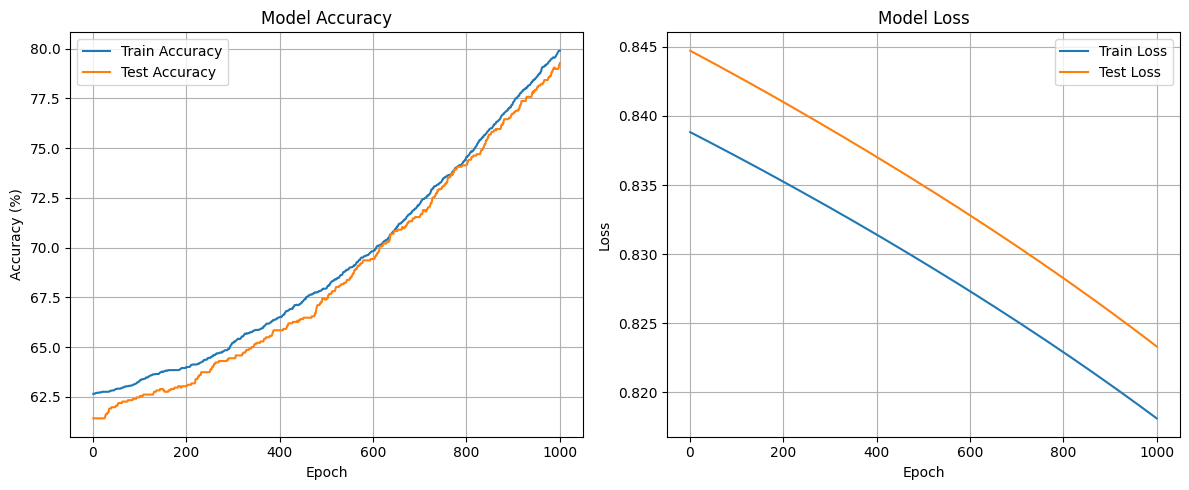

In [35]:
import matplotlib.pyplot as plt

epoch_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_range, track_accuracy, label='Train Accuracy')
plt.plot(epoch_range, track_test_accuracy, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epoch_range, track_loss, label='Train Loss')
plt.plot(epoch_range, track_test_loss, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Saving and loading already trained Model

Creating template / method for effective saving already trained model, so user don't have to wait for it to finish training before usage.

In [225]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory if it doesn't exist yet
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "nn_exoplanets0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/nn_exoplanets0.pth


In [197]:
!ls -l models

total 44
-rw-rw-r-- 1 maciekb maciekb 42159 Oct  4 13:36 nn_exoplanets0.pth


### Loading Trained model



In [188]:
# To load in a saved state_dict we have to instantiate a new instace of our model class
loaded_model_0 = ExoplanetsV0(input_features = 18, output_features = 1, hidden_units = 64)

#Load the saved state_dict of model_0 (update the new instance with old parameters
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [234]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_logits = loaded_model_0(X_test.to(device))
    loaded_pred_probs = torch.sigmoid(loaded_logits)
    loaded_preds = torch.round(loaded_pred_probs)

loaded_preds

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [235]:
loaded_preds == y_preds

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [237]:
loaded_preds, y_preds

(tensor([[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<RoundBackward0>))

# Looking for mistakes

### Balance between classes

In [192]:
print("class distribution y:")
print(f"Confirmed (1): {(y == 1).sum()} - {((y == 1).sum() / len(y)) * 100:.2f}%")
print(f"False Positive (0): {(y == 0).sum()} - {((y == 0).sum() / len(y)) * 100:.2f}%")

class distribution y:
Confirmed (1): 2734 - 38.43%
False Positive (0): 4381 - 61.57%


#### Fix 1. Using wage in loss_fn

Using wage in BCEWithLogitsLoss()

#### Fix 2. Using fake data to check if model is learning anything

In [193]:
import numpy as np
import torch
from sklearn.datasets import make_classification

# Stwórz sztuczne dane które NA PEWNO są przewidywalne
X_easy, y_easy = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=8,  # 8 użytecznych features
    n_redundant=2,  # 2 zbędne features
    n_clusters_per_class=1,
    random_state=42
)

# Konwersja do tensorów
X_easy_tensor = torch.from_numpy(X_easy).float()
y_easy_tensor = torch.from_numpy(y_easy).float()

print(f"Easy data - X: {X_easy_tensor.shape}, y: {y_easy_tensor.shape}")
print(f"Class balance: {y_easy.mean():.3f} positive")

Easy data - X: torch.Size([2000, 10]), y: torch.Size([2000])
Class balance: 0.497 positive


In [194]:
# Test on easy data
def test_your_model():
    # Generate easy data (18 features like in  original data)
    X_easy, y_easy = make_classification(
        n_samples=2000,
        n_features=18,  # SAME AS IN DATA
        n_informative=16,  # Most features are useful
        n_redundant=2,
        n_clusters_per_class=1,
        random_state=42,
        flip_y=0.01  # Only 1% noise
    )

    # Convert to tensors -
    X_easy_tensor = torch.from_numpy(X_easy).float()
    y_easy_tensor = torch.from_numpy(y_easy).float()

    # Train/test split
    split_idx = int(0.8 * len(X_easy_tensor))
    X_train = X_easy_tensor[:split_idx]
    X_test = X_easy_tensor[split_idx:]
    y_train = y_easy_tensor[:split_idx]
    y_test = y_easy_tensor[split_idx:]

    # USE EXACT MODEL
    model = ExoplanetsV0(input_features=18, output_features=1, hidden_units=128)

    # USED HYPERPARAMETERS (you can also test different ones)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)  # optimizer
    loss_fn = nn.BCEWithLogitsLoss()  # loss function

    print("=== TESTING YOUR MODEL ON EASY DATA ===")
    print(f"Model: {model}")
    print(f"Optimizer: SGD lr=0.01")
    print(f"Data: {X_train.shape} -> {y_train.shape}")

    # Training
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_logits = model(X_train).squeeze()

        # prediction logic
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Loss
        loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss with logits
        acc = (y_pred == y_train).float().mean()

        # Backward
        loss.backward()
        optimizer.step()

        # Test every 20 epochs
        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                test_logits = model(X_test).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                test_loss = loss_fn(test_logits, y_test)
                test_acc = (test_pred == y_test).float().mean()

            print(
                f"Epoch {epoch:3d} | Train Loss: {loss:.4f}, Acc: {acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    final_test_acc = (test_pred == y_test).float().mean()
    print(f"\n FINAL TEST ACCURACY: {final_test_acc:.4f}")

    if final_test_acc > 0.85:
        print("MODEL WORKS CORRECTLY - problem is in KEPLER DATA")
        return True
    elif final_test_acc > 0.6:
        print("MODEL WORKS POORLY - possible architecture problem")
        return False
    else:
        print("MODEL DOESN'T WORK - problem in IMPLEMENTATION")
        return False


# Run test
print("Testing YOUR exact model on easy data...")
model_works = test_your_model()

Testing YOUR exact model on easy data...
=== TESTING YOUR MODEL ON EASY DATA ===
Model: ExoplanetsV0(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
Optimizer: SGD lr=0.01
Data: torch.Size([1600, 18]) -> torch.Size([1600])
Epoch   0 | Train Loss: 0.6905, Acc: 0.5375 | Test Loss: 0.6859, Acc: 0.5625
Epoch  20 | Train Loss: 0.6617, Acc: 0.7350 | Test Loss: 0.6570, Acc: 0.7750
Epoch  40 | Train Loss: 0.6356, Acc: 0.7756 | Test Loss: 0.6302, Acc: 0.7825
Epoch  60 | Train Loss: 0.6073, Acc: 0.8019 | Test Loss: 0.6013, Acc: 0.8000
Epoch  80 | Train Loss: 0.5749, Acc: 0.8225 | Test Loss: 0.5681, Acc: 0.8175

 FINAL TEST ACCURACY: 0.8175
MODEL WORKS POORLY - possible architecture problem


### Conclusion

Problem in `Sigmoid()` in `nn.Sequential`. Sigmoid should be used to round when we want to convert logits > probs > labels, it was affecting final answer when used in wrong place.

Model can achieve ~60% accuracy on Dataset, let's try wages now, with working implementation. -> Model achieves over 90% accuracy.

### Observations

* When applied change and increased number of hidden layers
    * `Linear>ReLU>Linear>ReLU>Linear>` -> `Linear>ReLU>Linear>ReLU>Linear>ReLU>Linear` accuracy dropped to 60,5% and model wasn't learning